# Mapping Crypto Communities in r/CryptoMoonShots

In this notebook we analyze posts from the **r/CryptoMoonShots** subreddit.

- We use the **post text** (title + selftext) to extract mentioned coins (tickers).
- We build a **co-mention network** where nodes are coins and edges connect coins mentioned in the same post.
- This network will later be analyzed with **network science tools** (centrality, communities, assortativity) and combined with **NLP** (TF-IDF, sentiment).


In [ ]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt

plt.style.use("default")

FOLDER = "data/"

CSV_PATH = "cryptomoonshots.csv"  

df = pd.read_csv(FOLDER + CSV_PATH)

print("Shape:", df.shape)
df.head()


Shape: (60711, 25)


,submission,subreddit,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,rt6sam,cryptomoonshots,Cryptoredditshots,1640995493,1641139727,0,0,0,0,1,...,BSC Token,1.0,1,0,0,1,0,[removed],default,https://redd.it/rt6sam
1,rt6td8,cryptomoonshots,diehthrindel,1640995586,1641139727,0,0,0,0,1,...,Warning,1.0,1,0,0,1,0,[removed],default,https://redd.it/rt6td8
2,rt6w3c,cryptomoonshots,[deleted],1640995829,1641139727,0,0,0,0,1,...,BSC Token,1.0,1,0,0,1,0,[removed],default,https://redd.it/rt6w3c
3,rt6xvs,cryptomoonshots,Apprehensive_Goat567,1640995973,1641139727,0,0,0,0,1,...,ERC-20 Token,1.0,1,0,0,1,0,[removed],default,https://redd.it/rt6xvs
4,rt6yu2,cryptomoonshots,Cassietron7140,1640996058,1641139727,0,0,0,0,0,...,NFT Collection,1.0,8,0,0,9,0,Early Alpha launch happening at midnight on Ne...,self,https://redd.it/rt6yu2


## Text cleaning and tokenization

We now preprocess the textual fields (mainly `title` and `selftext`):

- convert to lower-case
- remove URLs, emojis, HTML entities, and other noise
- remove crypto-marketing spam terms (e.g. “https”, “bscscan”, “airdrop”, “presale”, “telegram”, etc.)
- tokenize the text into word tokens and remove stopwords.

The cleaned tokens will be used both for **TF–IDF** and **sentiment analysis**.


In [ ]:
df["title"] = df["title"].fillna("")
df["selftext"] = df["selftext"].fillna("")

df["text_raw"] = df["title"].astype(str) + " " + df["selftext"].astype(str)
df["text_raw"] = df["text_raw"].str.strip()

df = df[df["text_raw"].str.len() > 0].copy()

mask_removed = df["selftext"].str.strip().isin(["[removed]", "[deleted]"])
df = df[~mask_removed].copy()

print("After cleaning:", df.shape)
df[["author", "title", "link_flair_text", "score", "text_raw"]].head(10)


After cleaning: (21115, 26)


,author,title,link_flair_text,score,text_raw
4,Cassietron7140,Amazing 3d/VR/MMO launching on Solana! | Vivaion,NFT Collection,8,Amazing 3d/VR/MMO launching on Solana! | Vivai...
6,AngelaPelton,🎉CHEEMS INU 22 🎉 1 BNB liquidity 🔥 Safe dev ✅ ...,BSC Token,6,🎉CHEEMS INU 22 🎉 1 BNB liquidity 🔥 Safe dev ✅ ...
11,terfinfo,Dinner4One has Zero tax | 1k MC | last project...,BSC Token,13,Dinner4One has Zero tax | 1k MC | last project...
13,AnniePetz,Astro🦍Ape | 3k marketcap | Liquidity locked | ...,BSC Token,12,Astro🦍Ape | 3k marketcap | Liquidity locked | ...
14,Thethiala,Museo ($MSE) - VR NFTs 🔥 Active Nationwide Bil...,BSC Token,135,Museo ($MSE) - VR NFTs 🔥 Active Nationwide Bil...
15,skewbed,"Climb Everest Coin - Climbing to $29,032 [Mark...",BSC Token,10,"Climb Everest Coin - Climbing to $29,032 [Mark..."
22,Important-Sink-9660,Chiba Inu - Listed on Flooz Today! - 5th day s...,BSC Token,161,Chiba Inu - Listed on Flooz Today! - 5th day s...
23,DanicaMichaux,Coin Vip Just Launched Hold Coin Vip and Get i...,BSC Token,7,Coin Vip Just Launched Hold Coin Vip and Get i...
28,rgarciagdt,KeyCash Game is Live 🔥 Powered by Cashio.io To...,BSC Token,6,KeyCash Game is Live 🔥 Powered by Cashio.io To...
31,sasasasa0909,🐵 Chimpstronaut 🐵 | 🎨 NFT Collection |📋 Longte...,BSC Token,9,🐵 Chimpstronaut 🐵 | 🎨 NFT Collection |📋 Longte...


In [ ]:
def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"0x[a-f0-9]{6,}", " ", text)
    text = text.replace("&amp;", " ")
    return text.strip()

df["text"] = df["text_raw"].apply(clean)

df[["title", "text"]].head(5)


,title,text
4,Amazing 3d/VR/MMO launching on Solana! | Vivaion,amazing 3d/vr/mmo launching on solana! | vivai...
6,🎉CHEEMS INU 22 🎉 1 BNB liquidity 🔥 Safe dev ✅ ...,🎉cheems inu 22 🎉 1 bnb liquidity 🔥 safe dev ✅ ...
11,Dinner4One has Zero tax | 1k MC | last project...,dinner4one has zero tax | 1k mc | last project...
13,Astro🦍Ape | 3k marketcap | Liquidity locked | ...,astro🦍ape | 3k marketcap | liquidity locked | ...
14,Museo ($MSE) - VR NFTs 🔥 Active Nationwide Bil...,museo ($mse) - vr nfts 🔥 active nationwide bil...


In [ ]:
TICKER_RE = re.compile(r"\$[A-Za-z][A-Za-z0-9]{1,9}")

def extract_tickers(text: str):
    if not isinstance(text, str):
        return []
    tickers = set()
    for m in TICKER_RE.finditer(text):
        t = m.group(0)[1:].upper()
        tickers.add(t)
    return sorted(tickers)

df["tickers"] = df["text"].apply(extract_tickers)

df_sample = df[df["tickers"].str.len() > 0].head(10)
df_sample[["title", "text", "tickers"]]


,title,text,tickers
14,Museo ($MSE) - VR NFTs 🔥 Active Nationwide Bil...,museo ($mse) - vr nfts 🔥 active nationwide bil...,[MSE]
23,Coin Vip Just Launched Hold Coin Vip and Get i...,coin vip just launched hold coin vip and get i...,"[LUX, SPA, VIP]"
31,🐵 Chimpstronaut 🐵 | 🎨 NFT Collection |📋 Longte...,🐵 chimpstronaut 🐵 | 🎨 nft collection |📋 longte...,[CHIMP]
34,🐵 Chimpstronaut 🐵 |👨‍🎓 Privately Doxxed Devs |...,🐵 chimpstronaut 🐵 |👨‍🎓 privately doxxed devs |...,[CHIMP]
41,🐵 Chimpstronaut 🐵 |💰 Daily Competitions | 👨‍🎓 ...,🐵 chimpstronaut 🐵 |💰 daily competitions | 👨‍🎓 ...,[CHIMP]
44,ULTI ARENA | CMC & Coingecko | Doxed Team | Fr...,ulti arena | cmc & coingecko | doxed team | fr...,[ULTI]
45,ULTI ARENA | NFT Marketplace Live | Staking & ...,ulti arena | nft marketplace live | staking & ...,[ULTI]
48,Ulti Arena | Biggest NFT and Gaming Marketplac...,ulti arena | biggest nft and gaming marketplac...,[ULTI]
50,🐯 New Yeah Tiger ($NYT) 🐯 | Stealth launched 1...,🐯 new yeah tiger ($nyt) 🐯 | stealth launched 1...,[NYT]
52,🐵 Chimpstronaut 🐵 |99k MC | 💰 Daily Competitio...,🐵 chimpstronaut 🐵 |99k mc | 💰 daily competitio...,[CHIMP]


In [ ]:
n_with_ticker = (df["tickers"].str.len() > 0).sum()
print(f"Posts with >= 1 ticker: {n_with_ticker} / {len(df)}")

ticker_counts = {}

for tickers in df["tickers"]:
    for t in tickers:
        ticker_counts[t] = ticker_counts.get(t, 0) + 1

ticker_series = pd.Series(ticker_counts).sort_values(ascending=False)
print("Top tickers:")
ticker_series.head(20)


Posts with >= 1 ticker: 9851 / 21115
Top tickers:


BUSD        499
BNB         284
SHIB        135
DOGE        129
CHIMP       127
LAB          98
IWR          77
SFP          70
METALAND     70
FLOKI        69
SUUPER       63
APE          61
CAKE         60
FLASK        57
ETH          55
WEB3         50
ERX          49
DIGGER       45
USDT         43
TWEP         42
dtype: int64

## Network construction (co-mention graph)

In [ ]:
G = nx.Graph()

for _, row in df.iterrows():
    coins = row["tickers"]
    if not coins or len(coins) < 2:
        continue

    for c in coins:
        if not G.has_node(c):
            G.add_node(c)

    for i in range(len(coins)):
        for j in range(i + 1, len(coins)):
            u, v = coins[i], coins[j]
            if G.has_edge(u, v):
                G[u][v]["weight"] += 1
            else:
                G.add_edge(u, v, weight=1)

print(f"Co-mention network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

MIN_WEIGHT = 2
edges_to_remove = [(u, v) for u, v, w in G.edges(data="weight") if w < MIN_WEIGHT]
G.remove_edges_from(edges_to_remove)

print(f"After filtering weight<{MIN_WEIGHT}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Co-mention network: 1425 nodes, 1843 edges
After filtering weight<2: 1425 nodes, 600 edges


GCC: 269 nodes, 424 edges


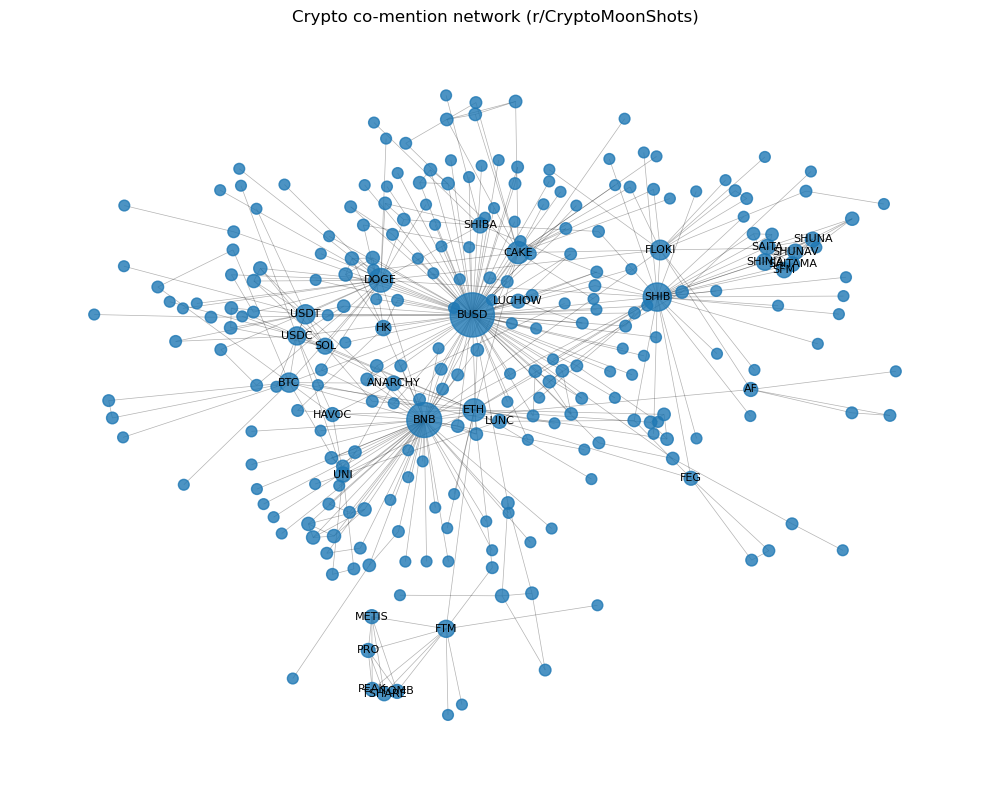

In [ ]:
if G.number_of_nodes() > 0:
    UG = G.copy() 
    if not nx.is_connected(UG):
        gcc_nodes = max(nx.connected_components(UG), key=len)
        UG = UG.subgraph(gcc_nodes).copy()
    else:
        gcc_nodes = UG.nodes()

    print(f"GCC: {len(gcc_nodes)} nodes, {UG.number_of_edges()} edges")

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(UG, seed=42, k=0.3)

    degrees = dict(UG.degree())
    sizes = [50 + 10 * degrees[n] for n in UG.nodes()]

    nx.draw_networkx_nodes(UG, pos, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(UG, pos, width=0.5, alpha=0.3)
    nx.draw_networkx_labels(
        UG, pos,
        labels={n: n for n, d in degrees.items() if d >= 5},
        font_size=8
    )

    plt.title("Crypto co-mention network (r/CryptoMoonShots)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Graph is empty, check ticker extraction or filters.")


## Community detection

Detected 1015 communities.


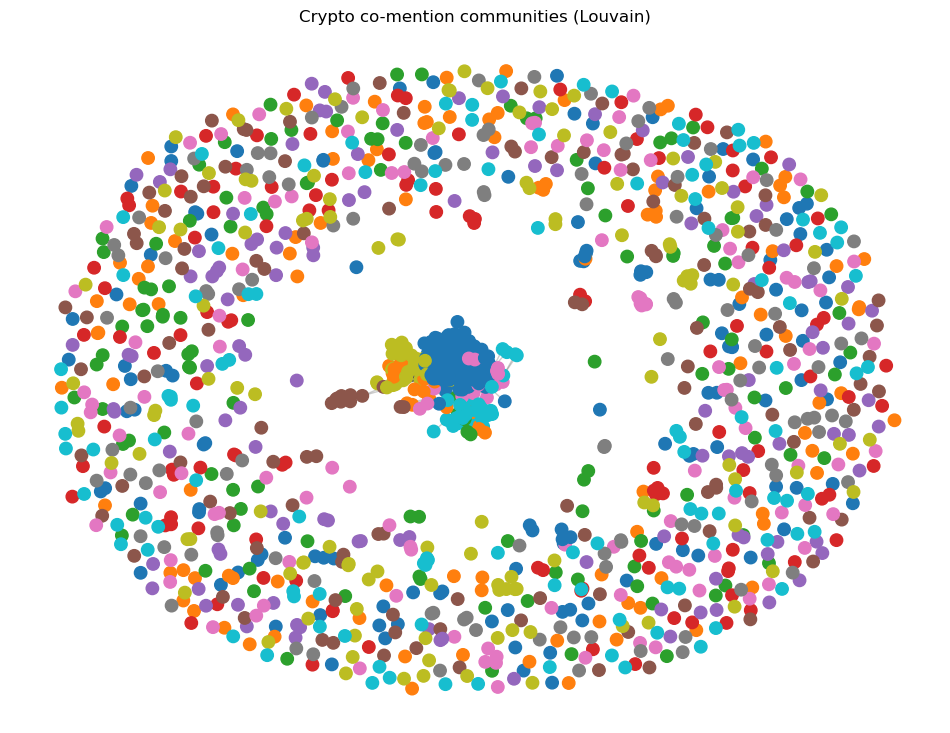

,community_id,size
0,87,78
1,14,46
2,955,45
3,865,38
4,120,19
...,...,...
1010,376,1
1011,377,1
1012,378,1
1013,379,1


In [ ]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

communities = community.louvain_communities(G, seed=42)
print(f"Detected {len(communities)} communities.")

comm_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        comm_map[node] = i

nx.set_node_attributes(G, comm_map, "community")

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42)
colors = [comm_map[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=colors, cmap=plt.cm.tab10)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Crypto co-mention communities (Louvain)")
plt.axis("off")
plt.show()

sizes = pd.Series([len(c) for c in communities]).sort_values(ascending=False)
sizes_df = pd.DataFrame({"community_id": sizes.index, "size": sizes.values})
display(sizes_df)


## Centrality and structural network measures


In [ ]:
import networkx as nx
import pandas as pd

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

centrality_df = pd.DataFrame({
    "coin": list(G.nodes()),
    "degree": [degree_centrality[n] for n in G.nodes()],
    "betweenness": [betweenness_centrality[n] for n in G.nodes()],
    "eigenvector": [eigenvector_centrality[n] for n in G.nodes()],
    "community": [G.nodes[n].get("community") for n in G.nodes()]
})

top_central = centrality_df.sort_values("degree", ascending=False).head(15)
display(top_central)


,coin,degree,betweenness,eigenvector,community
3,BUSD,0.067416,0.020272,0.581837,87
35,BNB,0.040730,0.012164,0.333420,14
24,SHIB,0.025281,0.009470,0.175661,955
41,DOGE,0.016854,0.004537,0.165243,120
8,ETH,0.014747,0.005603,0.110071,865
80,CAKE,0.014045,0.004116,0.126282,638
32,FLOKI,0.010534,0.002829,0.084094,955
13,USDT,0.009831,0.001685,0.131516,865
90,BTC,0.009831,0.002557,0.133554,865
266,USDC,0.008427,0.001581,0.107245,865


In [ ]:
coin_to_comm = nx.get_node_attributes(G, "community")

def get_post_comms(tickers):
    comms = [coin_to_comm.get(t) for t in tickers if t in coin_to_comm]
    return list(set([c for c in comms if c is not None]))

df["communities"] = df["tickers"].apply(get_post_comms)

df[["title", "tickers", "communities"]].head(10)


,title,tickers,communities
4,Amazing 3d/VR/MMO launching on Solana! | Vivaion,[],[]
6,🎉CHEEMS INU 22 🎉 1 BNB liquidity 🔥 Safe dev ✅ ...,[],[]
11,Dinner4One has Zero tax | 1k MC | last project...,[],[]
13,Astro🦍Ape | 3k marketcap | Liquidity locked | ...,[],[]
14,Museo ($MSE) - VR NFTs 🔥 Active Nationwide Bil...,[MSE],[]
15,"Climb Everest Coin - Climbing to $29,032 [Mark...",[],[]
22,Chiba Inu - Listed on Flooz Today! - 5th day s...,[],[]
23,Coin Vip Just Launched Hold Coin Vip and Get i...,"[LUX, SPA, VIP]","[0, 1, 2]"
28,KeyCash Game is Live 🔥 Powered by Cashio.io To...,[],[]
31,🐵 Chimpstronaut 🐵 | 🎨 NFT Collection |📋 Longte...,[CHIMP],[739]


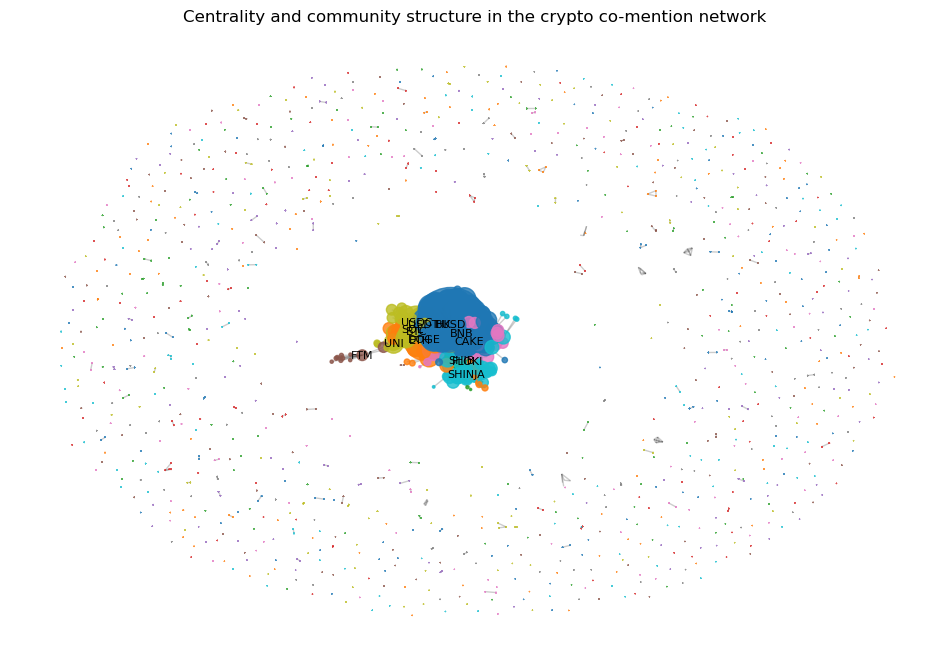

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

sizes = [5000 * eigenvector_centrality[n] for n in G.nodes()]
colors = [G.nodes[n].get("community", 0) for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap=plt.cm.tab10, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, {n: n for n in top_central["coin"]}, font_size=8)

plt.title("Centrality and community structure in the crypto co-mention network")
plt.axis("off")
plt.show()


In [ ]:
from collections import defaultdict

community_docs = defaultdict(list)

for _, row in df.iterrows():
    for c in row["communities"]:
        if isinstance(row["text"], str):
            community_docs[c].append(row["text"])


community_texts = {c: " ".join(texts) for c, texts in community_docs.items() if len(texts) > 0}

print(f"Collected text for {len(community_texts)} communities.")



Collected text for 1015 communities.


## TF–IDF analysis of communities


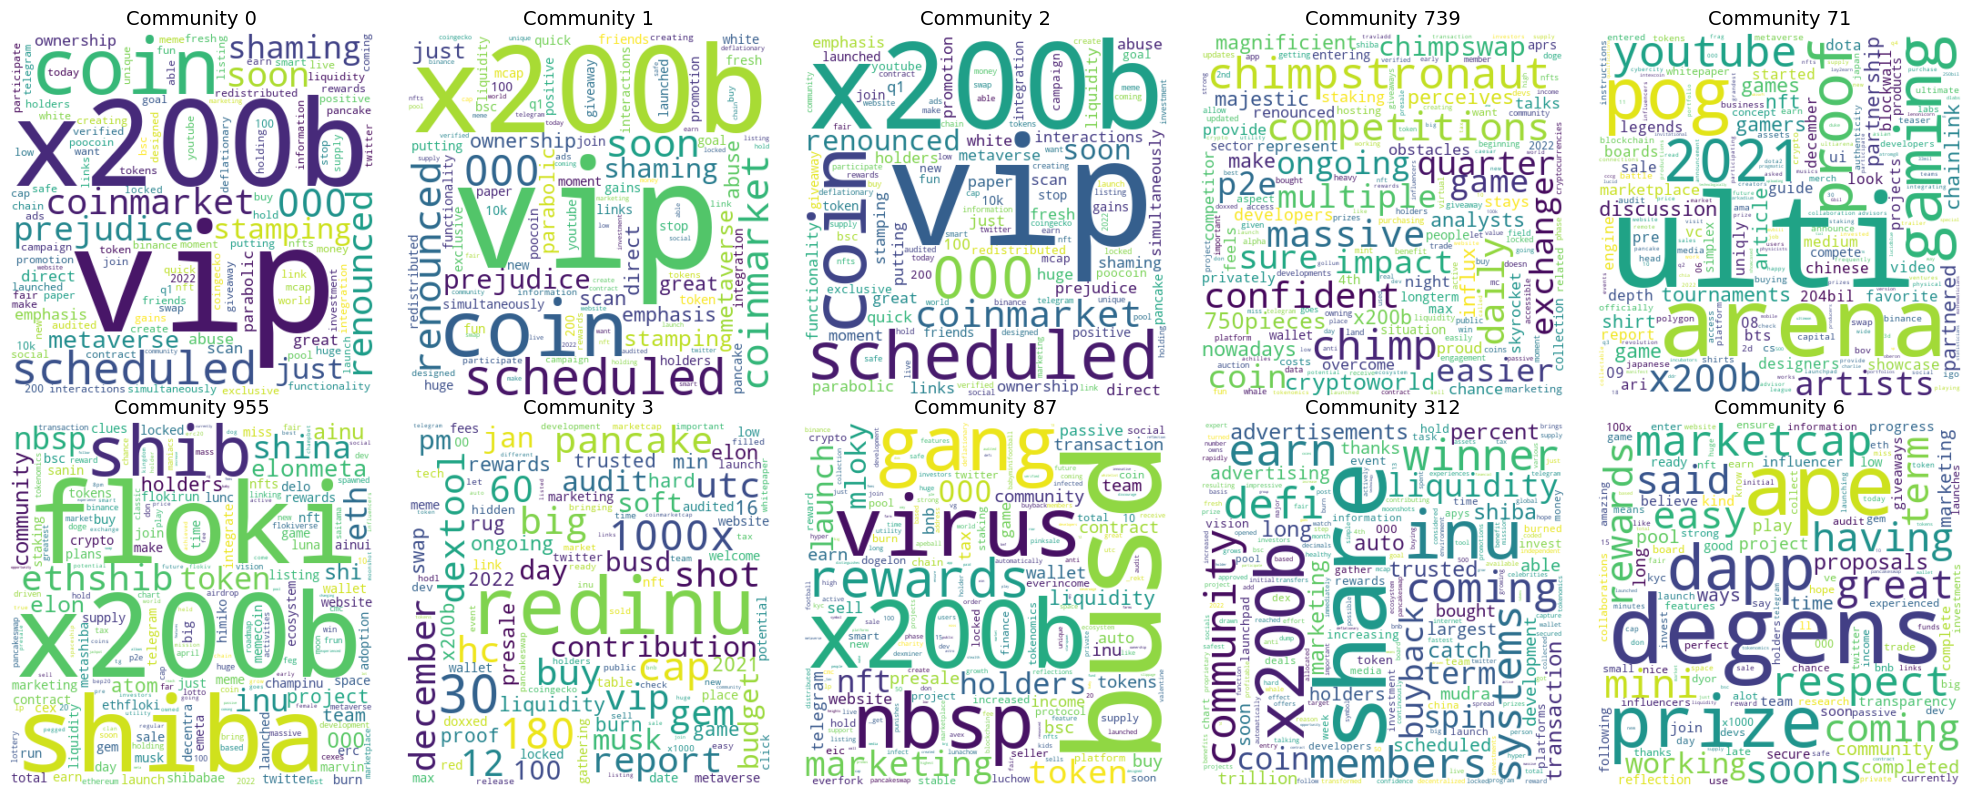

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(community_texts.values())
features = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X.T.toarray(), index=features, columns=community_texts.keys())

n_show = min(10, len(tfidf_df.columns))

cols = 5 
rows = math.ceil(n_show / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for i, c in enumerate(tfidf_df.columns[:n_show]):
    wordcloud = WordCloud(width=400, height=400, background_color="white").generate_from_frequencies(tfidf_df[c])
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {c}", fontsize=14)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## Sentiment analysis of posts and communities

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from statistics import mean, median

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

sentiment_stats = []

for c, text in community_texts.items():
    if not text.strip():
        continue
    scores = [sia.polarity_scores(sent)["compound"] for sent in text.split(".") if sent]
    if len(scores) > 0:
        sentiment_stats.append({
            "community": c,
            "mean": mean(scores),
            "median": median(scores),
            "count": len(scores)
        })

sent_df = pd.DataFrame(sentiment_stats).sort_values("mean", ascending=False)
display(sent_df.head(10))
display(sent_df.tail(10))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/birtos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,community,mean,median,count
114,74,0.98570,0.9857,2
158,121,0.98470,0.9847,1
159,122,0.98470,0.9847,1
449,385,0.94570,0.9457,1
448,384,0.94570,0.9457,1
591,539,0.92720,0.9272,1
592,540,0.92720,0.9272,1
847,820,0.92480,0.9248,2
404,341,0.92480,0.9248,1
462,400,0.91408,0.9186,5


,community,mean,median,count
418,356,-0.17200,-0.17200,2
417,355,-0.17200,-0.17200,2
155,117,-0.43115,-0.65365,6
587,536,-0.46960,-0.46960,1
588,534,-0.46960,-0.46960,1
455,393,-0.51985,-0.51985,2
230,187,-0.73990,-0.73990,1
231,188,-0.73990,-0.73990,1
293,233,-0.91690,-0.91690,1
292,232,-0.91690,-0.91690,1


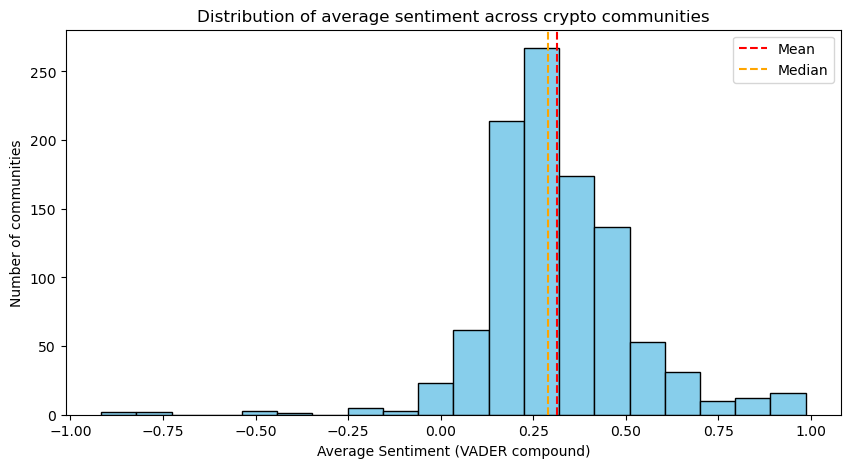

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(sent_df["mean"], bins=20, color="skyblue", edgecolor="black")
plt.axvline(sent_df["mean"].mean(), color="red", linestyle="--", label="Mean")
plt.axvline(sent_df["mean"].median(), color="orange", linestyle="--", label="Median")
plt.title("Distribution of average sentiment across crypto communities")
plt.xlabel("Average Sentiment (VADER compound)")
plt.ylabel("Number of communities")
plt.legend()
plt.show()


In [17]:
print("Top 2 happiest communities:")
display(sent_df.head(2))

print("Top 2 saddest communities:")
display(sent_df.tail(2))


Top 2 happiest communities:


,community,mean,median,count
114,74,0.9857,0.9857,2
158,121,0.9847,0.9847,1


Top 2 saddest communities:


,community,mean,median,count
293,233,-0.9169,-0.9169,1
292,232,-0.9169,-0.9169,1
